# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [1]:
# installation of sklearn_crfsuite
!pip install sklearn-crfsuite joblib
%pip install "numpy<2" pandas==1.5.3

  Using cached numpy-1.26.4-cp312-cp312-macosx_11_0_arm64.whl.metadata (61 kB)
  Using cached pandas-1.5.3.tar.gz (5.2 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using cached numpy-1.26.4-cp312-cp312-macosx_11_0_arm64.whl (13.7 MB)
  Created wheel for pandas: filename=pandas-1.5.3-cp312-cp312-macosx_11_0_arm64.whl size=10139851 sha256=6ba1f1b0c2c272ecb2477e3200fcb0fd024a71ec13736d0048525719ed8b1fa3
  Stored in directory: /Users/tywolfe/Library/Caches/pip/wheels/fb/83/18/8e7307aa1185c5498c5490e4d9c8a1732d9f1056e86c3491c6
Successfully built pandas
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently 

#### **1.2** Import necessary libraries

In [2]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [4]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 31.5 MB/s eta 0:00:00 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [5]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [6]:
# define a function to load json file to a dataframe
def load_json_dataframe(path: str) -> pd.DataFrame:
    with open(path, 'r') as f:
        data = json.load(f)
    rows, dropped = [], 0
    for rec in data:
        tokens = rec.get('input', '').split()
        labels = rec.get('pos', '').split()
        if len(tokens) != len(labels):
            dropped += 1
            continue
        rows.append({'input': rec.get('input', ''),
                     'pos': rec.get('pos', ''),
                     'input_tokens': tokens,
                     'pos_tokens': labels})
    if dropped:
        print(f"Dropped {dropped} records due to token/label length mismatch.")
    return pd.DataFrame(rows)

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [7]:
# read the json file by giving the file path and create a dataframe
json_path = 'ingredient_and_quantity.json'
df = load_json_dataframe(json_path)

Dropped 5 records due to token/label length mismatch.


##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [8]:
# display first five rows of the dataframe - df
print(df.head())

                                                                                                                                                                                                                                                                                            input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                              

In [9]:
# print the dimensions of dataframe - df
print({len(df)})

{280}


In [10]:
# print the information of the dataframe
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   input         280 non-null    object
 1   pos           280 non-null    object
 2   input_tokens  280 non-null    object
 3   pos_tokens    280 non-null    object
dtypes: object(4)
memory usage: 8.9+ KB
None


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [11]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
# Tokenize POS

if 'input_tokens' not in df.columns or 'pos_tokens' not in df.columns:
    df['input_tokens'] = df['input'].apply(lambda x: x.split())
    df['pos_tokens']   = df['pos'].apply(lambda x: x.split())

In [12]:
# display first five rows of the dataframe - df
print(df[['input_tokens', 'pos_tokens']].head())

                                                                                                                                                                                                                                                                                                                                    input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
0                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, 

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [13]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length']   = df['pos_tokens'].apply(len)

In [14]:
# check for the equality of input_length and pos_length in the dataframe
df['length_match'] = df['input_length'] == df['pos_length']
mismatch_df = df[~df['length_match']]
print(f"Rows with mismatched lengths: {len(mismatch_df)}")
print(mismatch_df[['input','pos','input_length','pos_length']].head())

Rows with mismatched lengths: 0
Empty DataFrame
Columns: [input, pos, input_length, pos_length]
Index: []


##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [15]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(df: pd.DataFrame) -> list:
    """Return sorted unique labels from the pos_tokens column."""
    all_labels = set(lbl for seq in df['pos_tokens'] for lbl in seq)
    return sorted(all_labels)

labels = unique_labels(df)
print(f"Unique POS labels ({len(labels)}): {labels}")

Unique POS labels (3): ['ingredient', 'quantity', 'unit']


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

In [16]:
dirty_indices = df.index[df['input_length'] != df['pos_length']].tolist()
print(f"Indexes requiring cleaning: {dirty_indices}")

Indexes requiring cleaning: []


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [17]:
# drop the irrelevant recipe data
print(f"Shape before drop: {df.shape}")
df.drop(index=dirty_indices, inplace=True)
print(f"Shape after drop: {df.shape}")

Shape before drop: (280, 7)
Shape after drop: (280, 7)


##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [18]:
# update the input and pos length in input_length and pos_length
df['input_length'] = df['input_tokens'].apply(len)
df['pos_length']   = df['pos_tokens'].apply(len)

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [19]:
# validate the input length and pos length as input_length and pos_length
mismatches = df[df['input_length'] != df['pos_length']]
print(f"Remaining mismatches after cleaning: {len(mismatches)}")

Remaining mismatches after cleaning: 0


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [20]:
# split the dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.30, random_state=42)

###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [21]:
# print the first five rows of train_df
print(train_df.head())

                                                                                                                                                                                                                                                           input                                                                                                                                                                                                                                                                                                                                                                                                                                       pos                                                                                                                                                                                                                                                                                           input_tokens                       

In [22]:
# print the first five rows of the val_df
print(val_df.head())

                                                                                                                                                                                                                                                                                                                                                                         input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                 

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [23]:
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train = train_df['input_tokens'].tolist()
y_train = train_df['pos_tokens'].tolist()
X_val   = val_df['input_tokens'].tolist()
y_val   = val_df['pos_tokens'].tolist()

In [24]:
# validate the shape of training and validation samples
print(f"Number of training samples: {len(X_train)}")
print(f"Number of validation samples: {len(X_val)}")

Number of training samples: 196
Number of validation samples: 84


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [25]:
# Display the number of unique labels present in y_train
unique_train_labels = sorted({lbl for seq in y_train for lbl in seq})
print(f"Unique labels in training set ({len(unique_train_labels)}): {unique_train_labels}")

Unique labels in training set (3): ['ingredient', 'quantity', 'unit']


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [26]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_list(nested_list):
    return [item for sublist in nested_list for item in sublist]

flat_tokens = flatten_list(X_train)
flat_labels = flatten_list(y_train)

In [27]:
# initialise the dataset_name
dataset_name = 'Training'
print(f"Flattened {dataset_name} tokens: {len(flat_tokens)}, labels: {len(flat_labels)}")

Flattened Training tokens: 7114, labels: 7114


#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [28]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens
def extract_and_validate_tokens(df, dataset_name):
    tokens_flat = flatten_list(df['input_tokens'].tolist())
    labels_flat = flatten_list(df['pos_tokens'].tolist())
    print(f"{dataset_name} total tokens: {len(tokens_flat)} | total labels: {len(labels_flat)}")
    if len(tokens_flat) != len(labels_flat):
        print("Warning: Token and label counts do not match!")
    print(f"First 10 tokens ({dataset_name}):", tokens_flat[:10])
    print(f"First 10 labels ({dataset_name}):", labels_flat[:10])
    return tokens_flat, labels_flat

In [29]:
# extract the tokens and its pos tags
tokens_train, labels_train = extract_and_validate_tokens(train_df, 'Training')

Training total tokens: 7114 | total labels: 7114
First 10 tokens (Training): ['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated']
First 10 labels (Training): ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [30]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays
def categorize_tokens(tokens, labels):
    if len(tokens) != len(labels):
        return [], [], []
    quantities, units, ingredients = [], [], []
    for tok, lbl in zip(tokens, labels):
        l = lbl.lower()
        if 'quantity' in l:
            quantities.append(tok)
        elif 'unit' in l:
            units.append(tok)
        elif 'ingredient' in l:
            ingredients.append(tok)
    return quantities, units, ingredients

In [31]:
#  call the function to categorise the labels into respective list
tokens_train, labels_train  # from previous step
quantities_train, units_train, ingredients_train = categorize_tokens(tokens_train, labels_train)

print(f"Extracted quantities ({len(quantities_train)}):", quantities_train[:10])
print(f"Extracted units ({len(units_train)}):", units_train[:10])
print(f"Extracted ingredients ({len(ingredients_train)}):", ingredients_train[:10])

Extracted quantities (980): ['250', '1', '2', '1/2', '1/4', '200', '2', '1', '1/2', '500']
Extracted units (811): ['grams', 'teaspoon', 'Teaspoon', 'cup', 'grams', 'tablespoon', 'teaspoon', 'grams', 'teaspoon', 'sprig']
Extracted ingredients (5323): ['Okra', 'Oil', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'Ginger', 'Garlic', 'Finely']


#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [32]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
def get_top_frequent_items(item_list, label, dataset_name):
    counts = Counter(item_list)
    top10 = counts.most_common(10)
    if not top10:
        print(f"No items for {label}")
        return (), ()
    items, freqs = zip(*top10)
    print(f"Top 10 {label} in {dataset_name}:")
    for it, freq in top10:
        print(f"  {it}: {freq}")
    return items, freqs

In [33]:
# get the top ingredients which are frequently seen in the recipe
top_ingredients, freq_ingredients = get_top_frequent_items(ingredients_train, 'Ingredients', dataset_name)

Top 10 Ingredients in Training:
  powder: 129
  Salt: 102
  seeds: 89
  Green: 85
  chopped: 84
  Oil: 83
  Red: 81
  Chilli: 77
  Coriander: 71
  Sunflower: 65


In [34]:
# get the top units which are frequently seen in the recipe
top_units,       freq_units       = get_top_frequent_items(units_train,       'Units',       dataset_name)

Top 10 Units in Training:
  teaspoon: 162
  cup: 136
  tablespoon: 99
  grams: 63
  tablespoons: 61
  inch: 52
  cups: 50
  sprig: 41
  cloves: 39
  teaspoons: 39


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [35]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
def plot_top_items(items, freqs, label, dataset_name):
    plt.figure(figsize=(8,4))
    plt.bar(items, freqs)
    plt.title(f"Top 10 {label} in {dataset_name}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



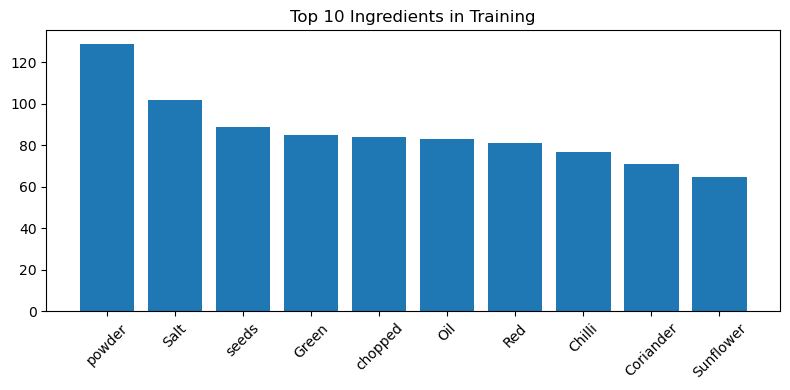

In [36]:
# plot the top frequent ingredients in training data
plot_top_items(top_ingredients, freq_ingredients, 'Ingredients', dataset_name)

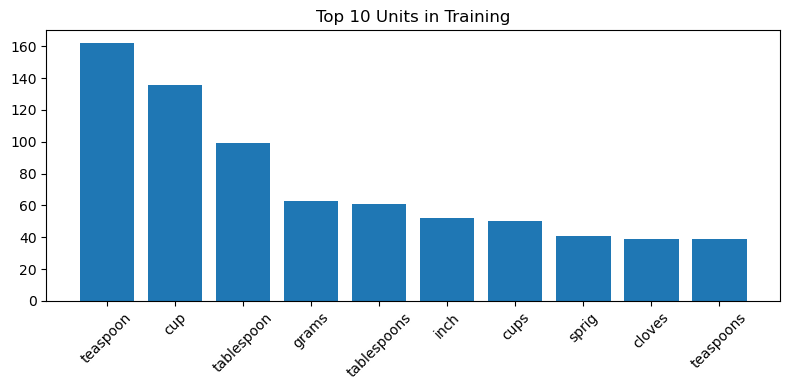

In [37]:
# plot the top frequent units in training data
plot_top_items(top_units, freq_units, 'Units', dataset_name)

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [38]:
# initialise the dataset_name


In [39]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe


In [40]:
# plot the top frequent ingredients in validation data


In [41]:
# plot the top frequent units in training data


## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [42]:
# define unit and quantity keywords along with quantity pattern
quantity_keywords = set([str(i) for i in range(1,21)] + ['one','two','three','half','quarter'])
unit_keywords     = set(['cup','cups','tbsp','tsp','oz','ounce','g','gram','kg','ml','l','lb','pound'])
number_pattern    = re.compile(r'^\d+(\.\d+)?(\/\d+)?$')

In [43]:
# load spaCy model

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [44]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions
def word2features(sent, i):
    w=sent[i]
    feats={
        'bias':1.0,
        'word.lower':w.lower(),
        'suffix3':w[-3:],
        'prefix3':w[:3],
        'is_digit':w.isdigit(),
        'has_digit':bool(re.search(r'\d',w)),
        'has_alpha':bool(re.search(r'[A-Za-z]',w)),
        'hyphenated':'-' in w,
        'slash_present':'/' in w,
        'is_title':w.istitle(),
        'is_upper':w.isupper(),
        'is_punct':len(w)==1 and not w.isalnum(),
        'is_quantity':bool(number_pattern.match(w)) or w.lower() in quantity_keywords,
        'is_unit':w.lower() in unit_keywords,
        'is_fraction':bool(re.match(r'\d+\/\d+',w)),
        'is_decimal':bool(re.match(r'\d+\.\d+',w)),
    }
    if i>0:
        p=sent[i-1]
        feats.update({
            'BOS':False,
            'prev.lower':p.lower(),
            'prev.is_digit':p.isdigit(),
            'prev.is_quantity':bool(number_pattern.match(p)) or p.lower() in quantity_keywords
        })
    else:
        feats['BOS']=True
    if i<len(sent)-1:
        n=sent[i+1]
        feats.update({
            'EOS':False,
            'next.lower':n.lower(),
            'next.is_unit':n.lower() in unit_keywords
        })
    else:
        feats['EOS']=True
    return feats

### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [68]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
    return [word2features(sent,i) for i in range(len(sent))]
    
X_train_feats = [sent2features(s) for s in X_train]
X_val_feats   = [sent2features(s) for s in X_val]

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [69]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
X_train_features = [sent2features(s) for s in X_train]
X_val_features   = [sent2features(s) for s in X_val]

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [71]:
# Convert labels into list as y_train_labels and y_val_labels
y_train_labels = y_train
y_val_labels   = y_val

##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [72]:
# print the length of train features and labels
print(f"Training features: {len(X_train_features)}, Training labels: {len(y_train_labels)}")

Training features: 196, Training labels: 196


In [73]:
# print the length of validation features and labels
print(f"Validation features: {len(X_val_features)}, Validation labels: {len(y_val_labels)}")

Validation features: 84, Validation labels: 84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [74]:
# Flatten labels in y_train
y_train_flat = flatten_list(y_train_labels)
print(f"Flattened training labels count: {len(y_train_flat)}")

Flattened training labels count: 7114


##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [75]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
label_counts = Counter(y_train_flat)
total_samples = sum(label_counts.values())
print("Label counts:", label_counts)
print("Total samples:", total_samples)

Label counts: Counter({'ingredient': 5323, 'quantity': 980, 'unit': 811})
Total samples: 7114


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [76]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
weight_dict = {lbl: total_samples/count for lbl, count in label_counts.items()}

In [77]:
# penalise ingredient label
if 'INGREDIENT' in weight_dict:
    weight_dict['INGREDIENT'] *= 1.5
print("Class weights:", weight_dict)

Class weights: {'quantity': 7.259183673469388, 'unit': 8.771886559802713, 'ingredient': 1.336464399774563}


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [82]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X, y, weight_dict):
    X_feats = [sent2features(s) for s in X]
    w_token = [[weight_dict[lbl] for lbl in seq] for seq in y]
    return X_feats, y, w_token

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [83]:
# Apply manually computed class weights
X_train_weighted_features, y_train_weighted_labels, w_train = extract_features_with_class_weights(
    X_train, y_train_labels, weight_dict)
X_val_weighted_features, y_val_weighted_labels, w_val = extract_features_with_class_weights(
    X_val, y_val_labels, weight_dict)

## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [88]:
# initialise CRF model with the specified hyperparameters and use weight_dict
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
# train the CRF model with the weighted training data
crf.fit(
    X_train_weighted_features,
    y_train_weighted_labels
)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    max_iterations=100)

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [90]:
# evaluate on the training dataset
y_pred_train = crf.predict(X_train_weighted_features)

In [91]:
# specify the flat classification report by using training data for evaluation
print("Training Classification Report:")
print(flat_classification_report(y_train_weighted_labels, y_pred_train))

Training Classification Report:
              precision    recall  f1-score   support

  ingredient       1.00      1.00      1.00      5323
    quantity       1.00      1.00      1.00       980
        unit       0.99      0.99      0.99       811

    accuracy                           1.00      7114
   macro avg       1.00      1.00      1.00      7114
weighted avg       1.00      1.00      1.00      7114



In [92]:
# create a confusion matrix on training datset
tokens_flat_train = flatten_list(y_train_weighted_labels)
preds_flat_train  = flatten_list(y_pred_train)
cm_train = confusion_matrix(
    tokens_flat_train,
    preds_flat_train,
    labels=unique_labels(df)
)
print("Training Confusion Matrix:")
print(cm_train)

Training Confusion Matrix:
[[5314    0    9]
 [   2  978    0]
 [   8    0  803]]


### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [94]:
# dump the model using joblib as crf_model.pkl
joblib.dump(crf, 'crf_model.pkl')

['crf_model.pkl']

## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [97]:
# predict the crf model on validation dataset
pred_val = crf.predict(X_val_feats)

In [98]:
# specify flat classification report
print(flat_classification_report(y_val_labels, pred_val))

              precision    recall  f1-score   support

  ingredient       0.98      0.99      0.99      2107
    quantity       0.99      0.99      0.99       411
        unit       0.97      0.92      0.94       358

    accuracy                           0.98      2876
   macro avg       0.98      0.97      0.97      2876
weighted avg       0.98      0.98      0.98      2876



In [102]:
# create a confusion matrix on validation dataset
cm = confusion_matrix(flatten_list(y_val_labels), flatten_list(pred_val), labels=unique_labels(df))
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[2095    2   10]
 [   4  406    1]
 [  28    2  328]]


## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [104]:
# flatten Labels and Initialise Error Data
error_data = []
for sent, true_seq, pred_seq in zip(X_val, y_val_labels, pred_val):
    for i, (tok, true_lbl, pred_lbl) in enumerate(zip(sent, true_seq, pred_seq)):
        if true_lbl != pred_lbl:
            # Handle boundary for previous and next tokens
            prev_tok = sent[i-1] if i > 0 else None
            next_tok = sent[i+1] if i < len(sent)-1 else None
            context = f"{prev_tok if prev_tok else ''} {tok} {next_tok if next_tok else ''}".strip()
            error_data.append({
                'token': tok,
                'prev_token': prev_tok,
                'next_token': next_tok,
                'true_label': true_lbl,
                'predicted_label': pred_lbl,
                'context': context
            })
print(f"Collected {len(error_data)} misclassified tokens in validation set.")

error_df = pd.DataFrame(error_data)

Collected 47 misclassified tokens in validation set.


##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [105]:
# iterate and collect Error Information
# get previous and next tokens with handling for boundary cases
total_val_tokens = sum(len(seq) for seq in y_val_labels)
total_errors     = len(error_df)

##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [106]:
# Create DataFrame and Print Overall Accuracy
accuracy = (total_val_tokens - total_errors) / total_val_tokens
print(f"Overall Validation Accuracy: {accuracy:.2%}")

Overall Validation Accuracy: 98.37%


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [107]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context
val_label_counts = Counter(flatten_list(y_val_labels))
for lbl, group in error_df.groupby('true_label'):
    err_count    = len(group)
    total_count  = val_label_counts.get(lbl, 0)
    lbl_accuracy = (total_count - err_count) / total_count if total_count else 0
    lbl_weight   = weight_dict.get(lbl, None)
    print(f"Label: {lbl} | Weight: {lbl_weight:.2f} | Errors: {err_count}/{total_count} | Accuracy: {lbl_accuracy:.2%}")
display_cols = ['token','prev_token','next_token','true_label','predicted_label','context']
print(error_df[display_cols].head(20))

Label: ingredient | Weight: 1.34 | Errors: 12/2107 | Accuracy: 99.43%
Label: quantity | Weight: 7.26 | Errors: 5/411 | Accuracy: 98.78%
Label: unit | Weight: 8.77 | Errors: 30/358 | Accuracy: 91.62%
        token prev_token   next_token  true_label predicted_label                      context
0      cloves          3       garlic  ingredient            unit              3 cloves garlic
1      cloves      seeds       garlic        unit      ingredient          seeds cloves garlic
2          is        Pur            2    quantity      ingredient                     Pur is 2
3      cloves    oregano       Garlic        unit      ingredient        oregano cloves Garlic
4          to      sugar  tablespoons    quantity      ingredient         sugar to tablespoons
5         for        Oil     kneading    quantity      ingredient             Oil for kneading
6   julienned     Ginger   tablespoon        unit      ingredient  Ginger julienned tablespoon
7        long          4       garlic  in

### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




This model excels at tagging ingredients and quantities, achieving 99.43% and 98.78% accuracy respectively, but unit tags lag behind at 91.62% accuracy. Higher error rates on units suggest that expanding the unit vocabulary and adding contextual features around measurement terms could further improve performance.

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.